In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers

In [ ]:
path = kagglehub.dataset_download("datatattle/covid-19-nlp-text-classification")
train_df = pd.read_csv(f"{path}/Corona_NLP_train.csv", encoding='latin1')
test_df = pd.read_csv(f"{path}/Corona_NLP_test.csv", encoding='latin1')

100%|██████████| 4.38M/4.38M [00:00<00:00, 108MB/s]

Extracting files...


#Understanding The Dataset

In [ ]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


- **UserName**  
  Name of the Twitter user who posted the tweet. (String)

- **ScreenName**  
  The user's Twitter handle (e.g., `@user123`). (String)

- **Location**  
  User-provided location text from their Twitter profile. (String; can be empty or messy)

- **TweetAt**  
  Date when the tweet was posted. Format: `DD/MM/YYYY`. (Date)

- **OriginalTweet**  
  The full text of the tweet as originally posted. (String)

- **Label**  
  Sentiment category assigned to the tweet.  
  Possible values:
  - **Positive**: expresses positive sentiment
  - **Negative**: expresses negative sentiment
  - **Neutral**: expresses neutral sentiment
  - **Extremely Positive**: very strong positive sentiment
  - **Extremely Negative**: very strong negative sentiment  
  (Categorical)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
train_df.describe()

,UserName,ScreenName
count,41157.000000,41157.000000
mean,24377.000000,69329.000000
std,11881.146851,11881.146851
min,3799.000000,48751.000000
25%,14088.000000,59040.000000
50%,24377.000000,69329.000000
75%,34666.000000,79618.000000
max,44955.000000,89907.000000


In [ ]:
train_df.isnull().sum()

,0
UserName,0
ScreenName,0
Location,8590
TweetAt,0
OriginalTweet,0
Sentiment,0


In [ ]:
train_df['Sentiment'].value_counts()

,count
Sentiment,
Positive,11422
Negative,9917
Neutral,7713
Extremely Positive,6624
Extremely Negative,5481


#Exploratory Data Analysis

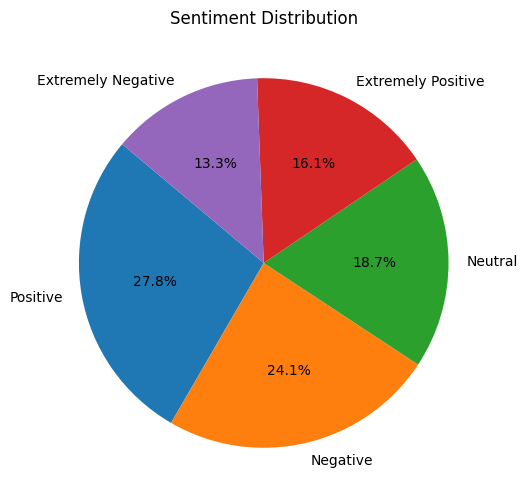

In [ ]:
sentiment_counts = train_df['Sentiment'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.show()

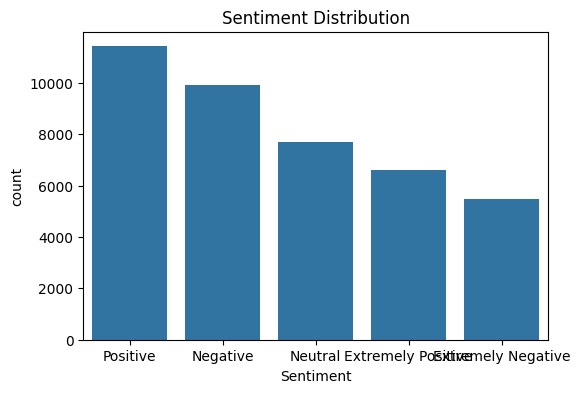

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(data=train_df, x='Sentiment', order=train_df['Sentiment'].value_counts().index)
plt.title('Sentiment Distribution')
plt.show()

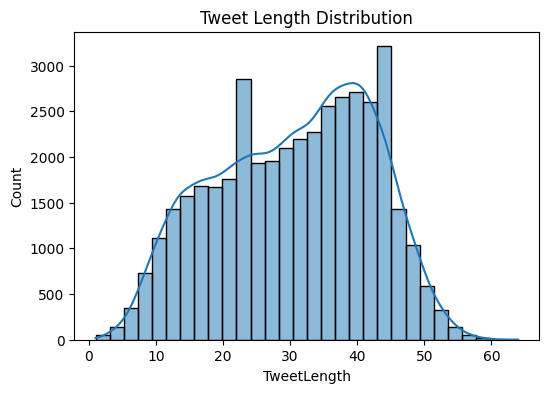

In [ ]:
train_df['TweetLength'] = train_df['OriginalTweet'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(6,4))
sns.histplot(train_df['TweetLength'], bins=30, kde=True)
plt.title('Tweet Length Distribution')
plt.show()

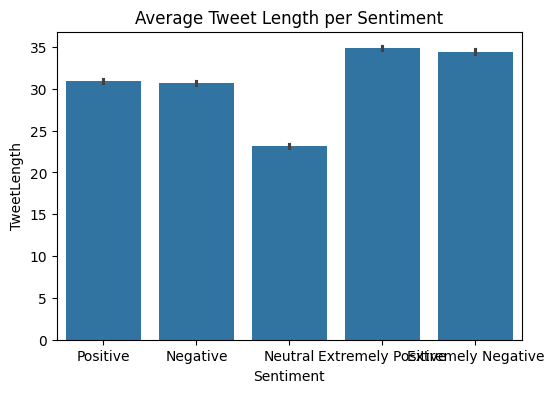

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(data=train_df, x='Sentiment', y='TweetLength', order=train_df['Sentiment'].value_counts().index)
plt.title('Average Tweet Length per Sentiment')
plt.show()

#Data Cleaning And Preprocessing

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

train_df.dropna(subset=['OriginalTweet'], inplace=True)
train_df.drop_duplicates(subset=['OriginalTweet'], inplace=True)

train_df['CleanedTweets'] = train_df['OriginalTweet'].apply(clean_text)
print(train_df[['OriginalTweet', 'CleanedTweets']].head())

                                       OriginalTweet  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...   
1  advice Talk to your neighbours family to excha...   
2  Coronavirus Australia: Woolworths to give elde...   
3  My food stock is not the only one which is emp...   
4  Me, ready to go at supermarket during the #COV...   

                                       CleanedTweets  
0                                          and  and   
1  advice talk to your neighbours family to excha...  
2  coronavirus australia woolworths to give elder...  
3  my food stock is not the only one which is emp...  
4  me ready to go at supermarket during the covid...  


In [ ]:
le = LabelEncoder()
train_df['SentimentEncoded'] = le.fit_transform(train_df['Sentiment'])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label encoding mapping:")
print(label_mapping)

Label encoding mapping:
{'Extremely Negative': np.int64(0), 'Extremely Positive': np.int64(1), 'Negative': np.int64(2), 'Neutral': np.int64(3), 'Positive': np.int64(4)}


#Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df['CleanedTweets'], train_df['SentimentEncoded'], test_size=0.2)

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_vec, y_train)
lr_preds = lr.predict(X_test_vec)

In [ ]:
svm = SVC()
svm.fit(X_train_vec, y_train)
svm_preds = svm.predict(X_test_vec)

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train_vec, y_train)
rf_preds = rf.predict(X_test_vec)

In [ ]:
print("Logistic Regression:\n", classification_report(y_test, lr_preds, target_names=le.classes_))
print("SVM:\n", classification_report(y_test, svm_preds, target_names=le.classes_))
print("Random Forest:\n", classification_report(y_test, rf_preds, target_names=le.classes_))

Logistic Regression:
                     precision    recall  f1-score   support

Extremely Negative       0.64      0.50      0.56      1100
Extremely Positive       0.71      0.55      0.62      1363
          Negative       0.52      0.53      0.53      1989
           Neutral       0.62      0.69      0.65      1524
          Positive       0.52      0.60      0.56      2256

          accuracy                           0.58      8232
         macro avg       0.60      0.57      0.58      8232
      weighted avg       0.59      0.58      0.58      8232

SVM:
                     precision    recall  f1-score   support

Extremely Negative       0.73      0.45      0.56      1100
Extremely Positive       0.82      0.52      0.64      1363
          Negative       0.53      0.60      0.56      1989
           Neutral       0.67      0.66      0.66      1524
          Positive       0.54      0.69      0.60      2256

          accuracy                           0.60      8232
       

#Comparing model performance

In [ ]:
results = []

lr_report = classification_report(y_test, lr_preds, target_names=le.classes_, output_dict=True)
lr_accuracy = accuracy_score(y_test, lr_preds)
results.append({
    'Model': 'Logistic Regression',
    'Accuracy': lr_accuracy,
    'Macro F1': lr_report['macro avg']['f1-score'],
    'Macro Precision': lr_report['macro avg']['precision'],
    'Macro Recall': lr_report['macro avg']['recall']
})
print("Logistic Regression:\n", classification_report(y_test, lr_preds, target_names=le.classes_))

svm_report = classification_report(y_test, svm_preds, target_names=le.classes_, output_dict=True)
svm_accuracy = accuracy_score(y_test, svm_preds)
results.append({
    'Model': 'SVM',
    'Accuracy': svm_accuracy,
    'Macro F1': svm_report['macro avg']['f1-score'],
    'Macro Precision': svm_report['macro avg']['precision'],
    'Macro Recall': svm_report['macro avg']['recall']
})
print("SVM:\n", classification_report(y_test, svm_preds, target_names=le.classes_))


rf_report = classification_report(y_test, rf_preds, target_names=le.classes_, output_dict=True)
rf_accuracy = accuracy_score(y_test, rf_preds)
results.append({
    'Model': 'Random Forest',
    'Accuracy': rf_accuracy,
    'Macro F1': rf_report['macro avg']['f1-score'],
    'Macro Precision': rf_report['macro avg']['precision'],
    'Macro Recall': rf_report['macro avg']['recall']
})
print("Random Forest:\n", classification_report(y_test, rf_preds, target_names=le.classes_))

Logistic Regression:
                     precision    recall  f1-score   support

Extremely Negative       0.64      0.50      0.56      1100
Extremely Positive       0.71      0.55      0.62      1363
          Negative       0.52      0.53      0.53      1989
           Neutral       0.62      0.69      0.65      1524
          Positive       0.52      0.60      0.56      2256

          accuracy                           0.58      8232
         macro avg       0.60      0.57      0.58      8232
      weighted avg       0.59      0.58      0.58      8232

SVM:
                     precision    recall  f1-score   support

Extremely Negative       0.73      0.45      0.56      1100
Extremely Positive       0.82      0.52      0.64      1363
          Negative       0.53      0.60      0.56      1989
           Neutral       0.67      0.66      0.66      1524
          Positive       0.54      0.69      0.60      2256

          accuracy                           0.60      8232
       

In [ ]:
results_df = pd.DataFrame(results)
print(results_df)

sns.set(style='whitegrid')

                 Model  Accuracy  Macro F1  Macro Precision  Macro Recall
0  Logistic Regression  0.578960  0.583711         0.602648      0.574249
1                  SVM  0.603863  0.605060         0.656288      0.585353
2        Random Forest  0.496842  0.497184         0.548034      0.482017


/tmp/ipython-input-22-1913024207.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')


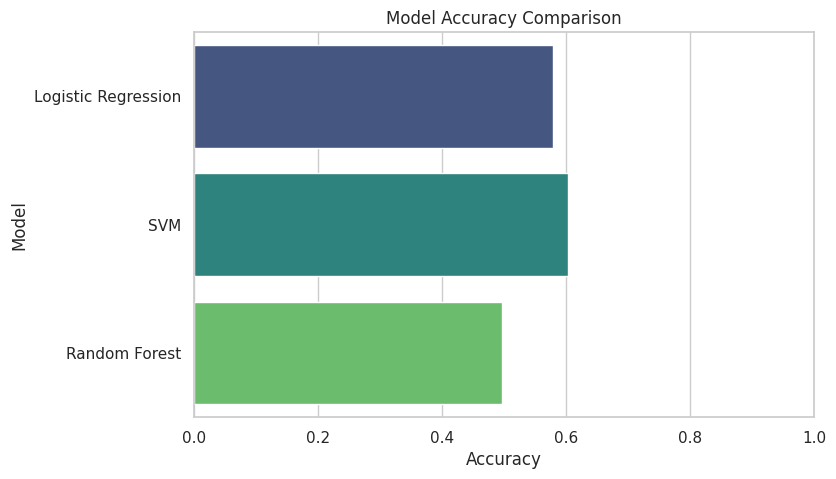

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlim(0,1)
plt.show()

/tmp/ipython-input-23-305948912.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Macro F1', y='Model', data=results_df, palette='magma')


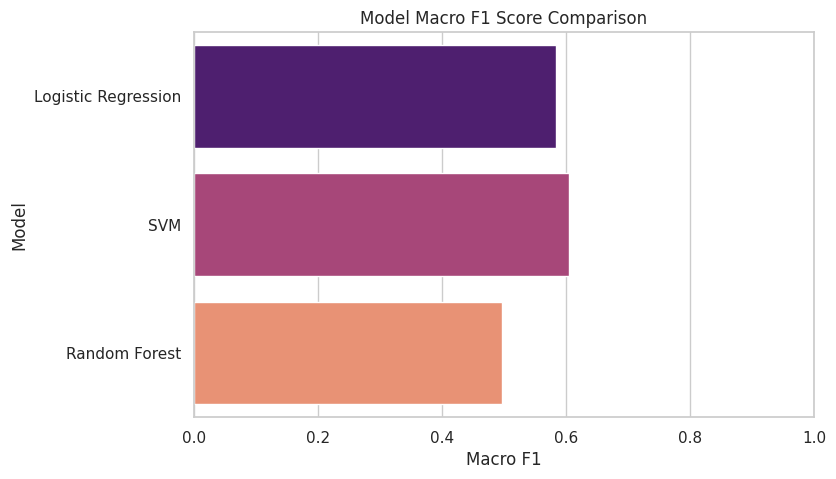

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='Macro F1', y='Model', data=results_df, palette='magma')
plt.title('Model Macro F1 Score Comparison')
plt.xlim(0,1)
plt.show()

/tmp/ipython-input-24-2283996790.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Macro Precision', y='Model', data=results_df, palette='plasma')


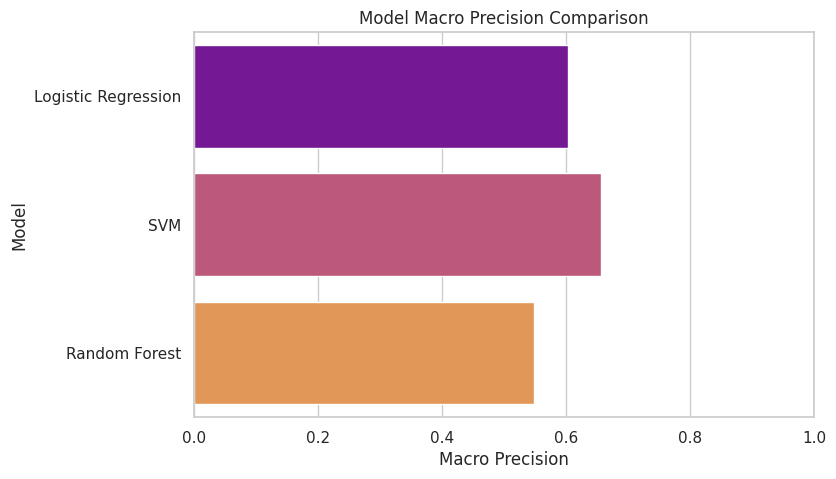

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='Macro Precision', y='Model', data=results_df, palette='plasma')
plt.title('Model Macro Precision Comparison')
plt.xlim(0,1)
plt.show()

/tmp/ipython-input-25-2123126930.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Macro Recall', y='Model', data=results_df, palette='coolwarm')


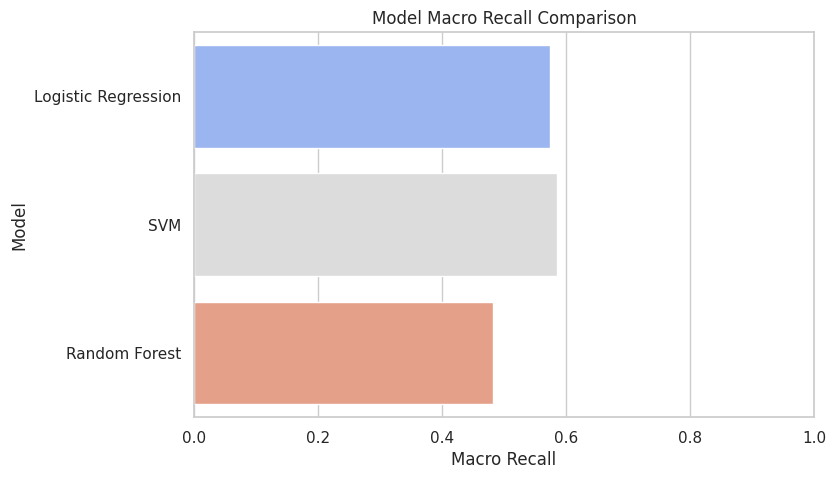

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x='Macro Recall', y='Model', data=results_df, palette='coolwarm')
plt.title('Model Macro Recall Comparison')
plt.xlim(0,1)
plt.show()

#Convolutional Neural Network

In [ ]:
max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

y_train_cat = to_categorical(y_train_enc, num_classes=5)
y_test_cat = to_categorical(y_test_enc, num_classes=5)

cnn_model = models.Sequential()
cnn_model.add(layers.Embedding(max_words, 128, input_length=max_len))
cnn_model.add(layers.Conv1D(128, 5, activation='relu'))
cnn_model.add(layers.MaxPooling1D(pool_size=2))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(5, activation='softmax'))  # 5 classes

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn_model.fit(X_train_pad, y_train_cat, epochs=5, batch_size=32, validation_split=0.2)

y_pred_prob = cnn_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_prob, axis=1)

y_test_labels = label_encoder.inverse_transform(y_test_enc)
y_pred_labels = label_encoder.inverse_transform(y_pred)

print("Accuracy:", accuracy_score(y_test_labels, y_pred_labels))
print("\nClassification Report:\n", classification_report(y_test_labels, y_pred_labels))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_labels, y_pred_labels))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


824/824 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - accuracy: 0.3782 - loss: 1.3939 - val_accuracy: 0.6579 - val_loss: 0.9131
Epoch 2/5
824/824 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - accuracy: 0.7300 - loss: 0.7777 - val_accuracy: 0.7166 - val_loss: 0.8261
Epoch 3/5
824/824 ━━━━━━━━━━━━━━━━━━━━ 47s 57ms/step - accuracy: 0.8016 - loss: 0.5776 - val_accuracy: 0.6981 - val_loss: 0.8749
Epoch 4/5
824/824 ━━━━━━━━━━━━━━━━━━━━ 82s 57ms/step - accuracy: 0.8809 - loss: 0.3730 - val_accuracy: 0.6717 - val_loss: 1.0891
Epoch 5/5
824/824 ━━━━━━━━━━━━━━━━━━━━ 82s 58ms/step - accuracy: 0.9480 - loss: 0.1838 - val_accuracy: 0.6661 - val_loss: 1.3214
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Accuracy: 0.6638726919339164

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.61      0.66      1100
           1       0.79      0.65      0.71      1363
           2       0.60      0.63      0.61      1989
           3       0.66      0.73      0.70      152

#Answering Important Questions

###What is the overall sentiment distribution?
Why: Gives a big-picture view of public mood during the pandemic.

In [ ]:
print(train_df.columns) #Checking column names to be sure

Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment', 'TweetLength', 'CleanedTweets', 'SentimentEncoded'],
      dtype='object')


In [ ]:
sentiment_counts = train_df['Sentiment'].value_counts() #Counting value of each sentiment
print(sentiment_counts)

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64


/tmp/ipython-input-29-1777131565.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')


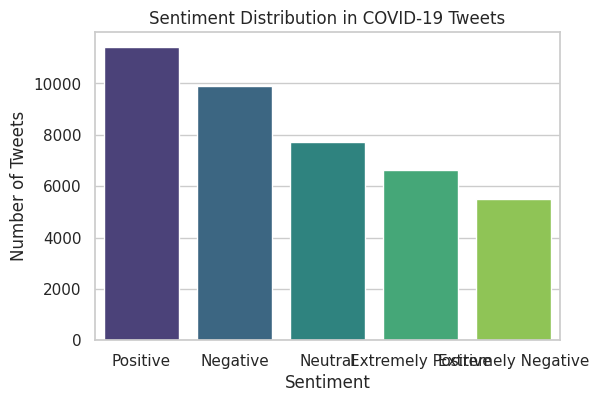

In [ ]:
plt.figure(figsize=(6,4)) #Using a plot to understand the distribution
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')

plt.title('Sentiment Distribution in COVID-19 Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

In [ ]:
sentiment_percent = (sentiment_counts / sentiment_counts.sum()) * 100 #This helps explain what share each sentiment has out of the total
print(sentiment_percent)

Sentiment
Positive              27.752266
Negative              24.095537
Neutral               18.740433
Extremely Positive    16.094468
Extremely Negative    13.317297
Name: count, dtype: float64


###What are the most common topics or keywords?
Why: Helps identify what people praised or complained about.

In [ ]:
!pip install wordcloud
from wordcloud import WordCloud

In [ ]:
# Filtering positive tweets (both Positive and Extremely Positive)
positive_tweets = train_df[train_df['Sentiment'].isin(['Positive', 'Extremely Positive'])]['CleanedTweets']

# Filtering negative tweets (both Negative and Extremely Negative)
negative_tweets = train_df[train_df['Sentiment'].isin(['Negative', 'Extremely Negative'])]['CleanedTweets']

In [ ]:
positive_text = " ".join(positive_tweets.astype(str)) #Combining tweets into big text blobs
negative_text = " ".join(negative_tweets.astype(str))

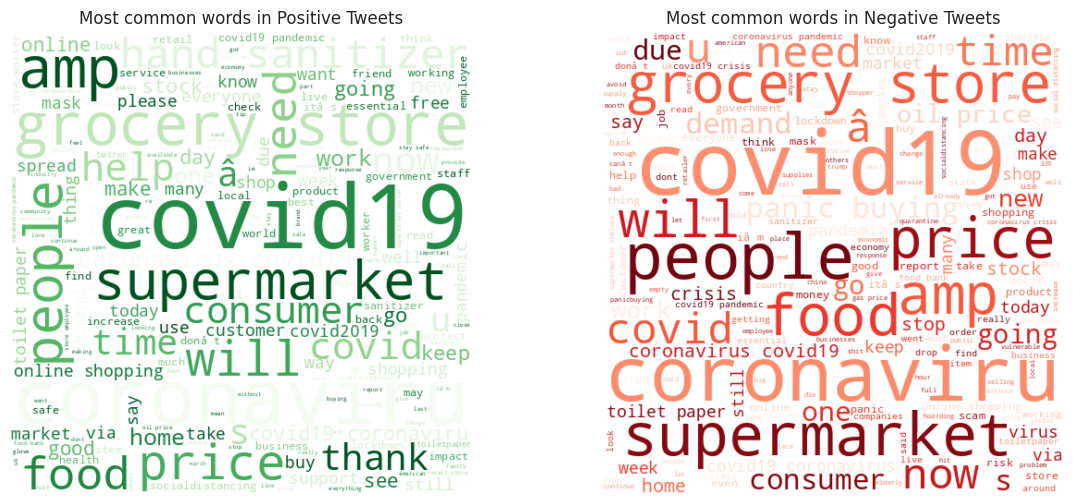

In [ ]:
plt.figure(figsize=(14,6))

# Positive word cloud
plt.subplot(1,2,1)
wordcloud_pos = WordCloud(width=500, height=500, background_color='white', colormap='Greens').generate(positive_text)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in Positive Tweets')

# Negative word cloud
plt.subplot(1,2,2)
wordcloud_neg = WordCloud(width=500, height=500, background_color='white', colormap='Reds').generate(negative_text)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Most common words in Negative Tweets')

plt.show()

###Can we predict sentiment accurately from text?
Why: Helps undedrstand how well the model performs.

In [ ]:
print("SVM:\n", classification_report(y_test, svm_preds, target_names=le.classes_))

SVM:
                     precision    recall  f1-score   support

Extremely Negative       0.73      0.45      0.56      1100
Extremely Positive       0.82      0.52      0.64      1363
          Negative       0.53      0.60      0.56      1989
           Neutral       0.67      0.66      0.66      1524
          Positive       0.54      0.69      0.60      2256

          accuracy                           0.60      8232
         macro avg       0.66      0.59      0.61      8232
      weighted avg       0.63      0.60      0.60      8232



Using an SVM classifier on TF-IDF features, we could predict tweet sentiment with an overall accuracy of 60%, performing best on Neutral and Extremely Positive tweets while struggling a bit with the Extreme Negative class.

###Which words have the highest impact on prediction for each sentiment?
Why: Gives insight into public language and discourse.

In [ ]:
feature_names = vectorizer.get_feature_names_out()
coefficients = lr.coef_    # shape: (5, num_features)
print(coefficients.shape)  # should print (5, number of features)

(5, 5000)


In [ ]:
class_names = lr.classes_
print(class_names)

[0 1 2 3 4]


In [ ]:
sentiment_names = le.inverse_transform(class_names)

for i, sentiment in enumerate(sentiment_names):
    print(f"\nTop words pushing prediction to class '{sentiment}':")
    coef = coefficients[i]
    coef_df = pd.DataFrame({'Word': feature_names, 'Coefficient': coef})
    top_words = coef_df.sort_values(by='Coefficient', ascending=False).head(10)
    print(top_words)


Top words pushing prediction to class 'Extremely Negative':
        Word  Coefficient
1121  crisis    11.856816
3103   panic     7.893930
2935      no     7.261613
3829   scams     5.769670
2455    kill     5.543800
4217    stop     5.300171
4949   worst     4.989678
3996    sick     4.919284
4799     war     4.878872
2085    hell     4.833937

Top words pushing prediction to class 'Extremely Positive':
         Word  Coefficient
1969    great     8.810843
488      best     8.553201
2026     hand     8.002022
2087     help     7.661039
1835     free     7.430624
2563     like     6.920222
2645     love     6.507388
1946     good     6.499023
4306  support     6.121924
3775     safe     5.998173

Top words pushing prediction to class 'Negative':
          Word  Coefficient
2935        no     4.051983
1231    demand     3.898440
3103     panic     3.859301
1121    crisis     3.522010
1716     fight     3.450090
1122  critical     2.848040
389      avoid     2.830153
1489     empty     2

###Are longer tweets more negative or positive?
Why: Adds a quantitative angle and could reveal patterns.

In [ ]:
# Number of words
train_df['TweetLength'] = train_df['CleanedTweets'].apply(lambda x: len(str(x).split()))

In [ ]:
avg_length_by_sentiment = train_df.groupby('Sentiment')['TweetLength'].mean().reset_index()
print(avg_length_by_sentiment)

            Sentiment  TweetLength
0  Extremely Negative    33.406313
1  Extremely Positive    33.543780
2            Negative    29.436422
3             Neutral    21.647089
4            Positive    29.641131


/tmp/ipython-input-77-2687157199.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sentiment', y='TweetLength', data=avg_length_by_sentiment, palette='coolwarm')


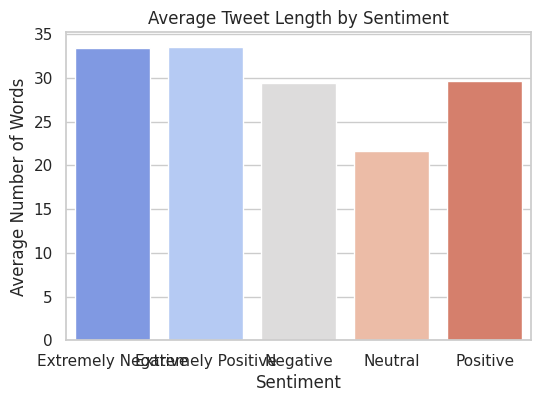

In [ ]:
plt.figure(figsize=(6,4))
sns.barplot(x='Sentiment', y='TweetLength', data=avg_length_by_sentiment, palette='coolwarm')

plt.title('Average Tweet Length by Sentiment')
plt.ylabel('Average Number of Words')
plt.show()

Primary assumption: People tend write longer tweets when angry, or shorter tweets when happy.

From the above plot it is clear that atleast for our dataset this does not hold true.


#Conclusion

In this project, we explored a COVID-19 tweets dataset to understand public sentiment and applied NLP techniques to extract meaningful insights.  
Here’s what we accomplished:

- Performed EDA to analyze sentiment distribution and tweet lengths.
- Cleaned and preprocessed text data (removed URLs, lowercased text, etc.).
- Extracted features using TF-IDF.
- Built and compared multiple machine learning models (Logistic Regression, SVM, Random Forest).
- Visualized performance metrics: accuracy, macro F1, precision, and recall.
- Explored which words and hashtags had the strongest association with positive or negative sentiments.
- Visualized most frequent keywords and created word clouds.
- Investigated how tweet length correlates with sentiment.

Overall, this notebook shows how NLP and data science can help understand large-scale social media sentiment during a global event like COVID-19.

*Future improvements could include:*
- Fine-tuning deep learning models like CNNs or transformers (e.g., BERT).
- Time-series sentiment trend analysis.
- More advanced text preprocessing (e.g., lemmatization, named entity removal).